In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [ ]:
from torchvision import transforms

my_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Alzheimer_s Dataset/train', transform=my_transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Alzheimer_s Dataset/test', transform=my_transform)

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

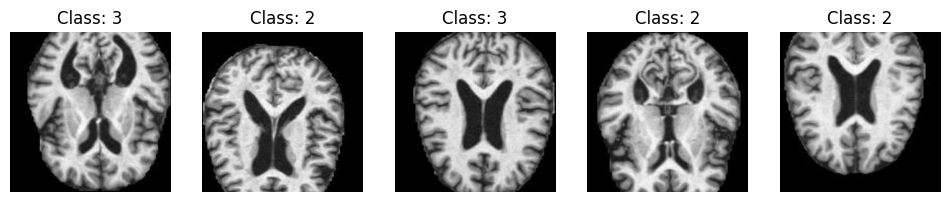

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(images, lables):
    fig, axes = plt.subplots(1, 5, figsize=(12, 6))
    for i, ax in enumerate(axes):
        image = images[i]
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title('Class: {}'.format(labels[i]))
        ax.axis('off')
    plt.show()

# Assuming you have a DataLoader object named 'train_loader'
batch = next(iter(train_loader))
images, labels = batch

# Show the images
show_images(images[:5], labels[:5])


In [ ]:
# Define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())


# Train the network
for epoch in range(70):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])


KeyboardInterrupt: ignored

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    predicted_labels = []
    true_labels = []
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_labels += predicted.tolist()
            true_labels += labels.tolist()
    accuracy = 100 * correct / total
    return accuracy, predicted_labels, true_labels

# Assuming you have a PyTorch model object named 'model'
# and a DataLoader object named 'val_loader'
accuracy, predicted_labels, true_labels = evaluate(net, test_loader)
print('Test accuracy: {:.2f}%'.format(accuracy))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(true_labels, predicted_labels)


# plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
#ax.xaxis.set_ticklabels(['class1', 'class2', 'class3', 'class4'])
#ax.yaxis.set_ticklabels(['class1', 'class2', 'class3', 'class4'])
plt.savefig('matrixc.png')
plt.show()